In [1]:
## import numpy as np
import pandas as pd
import numpy as np
%run '../Feature_Selection/custom_features.ipynb'

(1609, 39) 39


In [2]:
features_to_use=['VhonHeijne', 'tm_tendency_max', 'max_miyazawa_mean', 'chou_fasman_h_mean', 'flexibility_max', 'flexibility_mean', 'basicity', 'punta_mean', 'tm_tendency_mean', 'R', 'miyazawa_mean', 'punta_max', 'bulkiness_mean', 'L', 'C', 'chou_fasma_b_max', 'argos_mean', 'K', 'chou_fasma_b_mean', 'I', 'bulkiness_max', 'argos_max']

In [3]:
def update_vonheijne(sets, matrix): 
    seq_features=[]
    for seq in sets:
        seq=seq.replace("X" , "")
        seq=seq.replace("U" , "C")
        vonhejine=vonheijne_feature(matrix, seq) #get the von heijne feature for that sequence
        seq_features.append(vonhejine)
    hejine_col = np.array(seq_features) #transform the list that contains all the features in an array
    return hejine_col
    

In [4]:

#Load the npz files of training, testing and validation sets for each iteration
# load training
loaded_data_train = np.load('../Feature_Selection/training_features_1.npz')
x_train = loaded_data_train['matrix']
y_train = loaded_data_train['target']


# load test
loaded_data_test = np.load('../Feature_Selection/testing_features_1.npz')
x_test = loaded_data_test['matrix']
y_test = loaded_data_test['target']

# load validation
loaded_data_validation = np.load('../Feature_Selection/validation_features_1.npz')
x_validation = loaded_data_validation['matrix']
y_validation = loaded_data_validation['target']

#concatenate the matrices in the correct order
x_training_conc = np.concatenate((x_test, x_train), axis=0) 
y_training_conc = np.concatenate((y_test, y_train), axis=0)

# np.savez('training_features.npz', matrix=x_training_conc, target=y_training_conc)
# np.savez('validation_features.npz', matrix=x_validation, target=y_validation)

In [5]:
#Load the benchmark set and encode it
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")
benchmark=dataset.query("Set=='Benchmark'")
training=dataset.query("Set=='1' or Set=='3' or Set=='4' or Set== '5'")
validation=dataset.query("Set=='2'")
matrix_training=get_pswm(training , 13 , 2)
#replace the old VonHejine feature with the new VonHejine basing on the update PSWM
x_training_conc[:, 17] = update_vonheijne(training["Sequence"], matrix_training)
x_validation[:, 17] = update_vonheijne(validation["Sequence"], matrix_training)
feature_set_benchmark , feature_order_training = get_all_features(benchmark["Sequence"] , matrix_training, 15 )
vector_neg_pos = benchmark["Class"]
vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
target_benchmark_vector = vector_proper.to_numpy()
np.savez('benchmark_features.npz', matrix=feature_set_benchmark, target=target_benchmark_vector)
np.savez('training_features.npz', matrix=x_training_conc, target=y_training_conc)
np.savez('validation_features.npz', matrix=x_validation, target=y_validation)

In [20]:
index=[]
for feature in feature_order_training:
    if feature not in features_to_use:
        index.append(feature_order_training.index(feature))
x_training_conc=np.delete(x_training_conc, index, axis=1)
x_validation=np.delete(x_validation, index, axis=1)
x_benchmark=np.delete(feature_set_benchmark, index, axis=1)

## Hyperparameter Tuning

In [29]:
import numpy as np
from sklearn.metrics import matthews_corrcoef
#! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#create the pipeline
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC())])

In [19]:
# search spaces for rbf kernel and polynomial
search_spaces = [
    ({
        "svm__kernel": Categorical(["rbf"]),
        "svm__C": Real(0.01, 10, prior="log-uniform"),                
        "svm__gamma": Real(0.01, 10, prior="log-uniform"), 
    }, 5),
    ({
        "svm__kernel": Categorical(["poly"]),
        "svm__C": Real(0.01, 10, prior="log-uniform"),
        "svm__gamma": Real(0.01, 10, prior="log-uniform"),
        "svm__degree": Integer(1,2),
    }, 5),
]

# now we have to manually tell the BayesSearch function which datasets to use as training and validation
x_all = np.concatenate([x_training_conc, x_validation])
y_all = np.concatenate([y_training_conc, y_validation])

#we create arrays that map each training and testing example to -1 (training) or 0 (validatio)
test_fold = np.r_[
    -np.ones(len(x_training_conc), dtype=int),
     np.zeros(len(x_validation),   dtype=int)
]
#we create the predifined split
cv = PredefinedSplit(test_fold)

#set up the BayesSearch
bayes = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    scoring="matthews_corrcoef",   
    n_jobs=-1,
    refit=False,                 
    random_state=42,
    verbose=2, #proviamo a settarlo su 1
    cv=cv
)
bayes.fit(x_all, y_all)  # here we perform the bayes search

print("\n[Best parameters found:] ")
print(bayes.best_params_)
print(f"[Best MCC validation] {bayes.best_score_:.4f}")

# final refit
pipeline.set_params(**bayes.best_params_).fit(x_training_conc, y_training_conc)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] END svm__C=3.2521088005944945, svm__gamma=4.466278825224283, svm__kernel=rbf; total time=   1.5s
[CV] END svm__C=0.2160217783087772, svm__gamma=5.703843027403095, svm__kernel=rbf; total time=   1.4s
[CV] END svm__C=2.7364528220782454, svm__gamma=0.032780432870046915, svm__kernel=rbf; total time=   0.2s
[CV] END svm__C=2.5041499136197736, svm__gamma=0.2061045404501547, svm__kernel=rbf; total time=   0.5s
[CV] END svm__C=1.5925169151603527, svm__gamma=6.5782324054154415, svm__kernel=rbf; total time=   1.6s
[CV] END svm_

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,2.7364528220782454
,kernel,'rbf'
,degree,3
,gamma,0.032780432870046915


In [24]:
#predict the benchmark set
bench_pred = pipeline.predict(x_benchmark)
#compute the mcc
mcc = matthews_corrcoef(target_benchmark_vector , bench_pred)
print(f"MCC on testing set: {mcc}")

MCC on testing set: 0.6809615528946362


([<matplotlib.axis.YTick at 0x7f898b95fa10>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

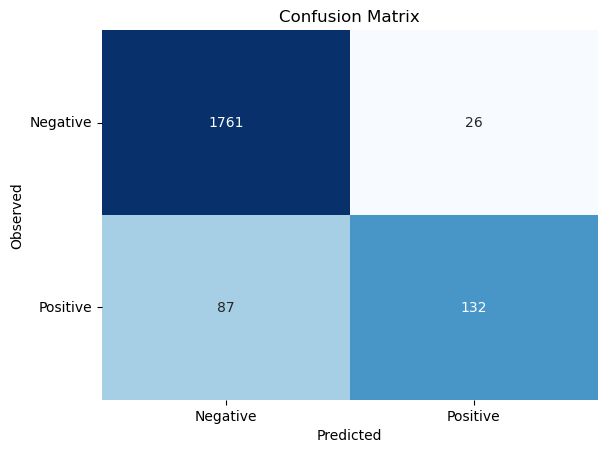

In [37]:
conf_mat = confusion_matrix(target_benchmark_vector , bench_pred)
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)

#### PROSSIMI STEPS
analizzare e creare distribuzioni dei falsi negativi e falsi positivi
per farlo dobbiamo estrarre le posizioni delle proteine false negative e false positive utilizzando i target vector e predicted vector
si può fare con la funzione zip: 
if observed == 0 e target == 1:
 allora false_negative.append(indice di quella proteina)
if observed == 1 e target == 0:
 allora false_positive.append(indice di quella proteina)
poi avendo gli index (che corrispondono a posizioni di righe nel dataframe del benchmark)
possiamo creare due nuovi dataframe e su quegli stronzi creare delle distribuzioni